# 2. Modelo Prophet

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
pip install prophet

Se separan los datos en train y test como corresponde.

In [97]:
df_Kern_train = pd.read_csv('Kern_train.csv')
df_Kern_test = pd.read_csv('Kern_test.csv')

## 2.1. Modelo para ventas totales

Se genera un primer modelo cuya finalidad será predecir las ventas mensuales de la empresa farmacéutica a lo largo del año 2025.

In [98]:
#Se cambia la fecha, ya que por defecto ponía día 1 del mes, pero realmente hace referencia a las ventas totales de el mes en cuestión
df_Kern_train['Fecha'] = pd.to_datetime(df_Kern_train['Fecha']).dt.to_period('M').dt.to_timestamp('M')
df_Kern_train.head()

,Código,Denominacion,Ventas,Fecha,Año
0,658257,PARACETAMOL KERN 1GRX40 CO EFG,29,2020-01-31,2020
1,958413,DIAZEPAN PRODES 5 MG 30 COMP,20,2020-01-31,2020
2,658256,PARACETAMOL KERN 1GRX20 CO EFG,30,2020-01-31,2020
3,687626,PARACETAMOL KERN PHARMA 500 MG 20 C EFG,15,2020-01-31,2020
4,673058,SULPIRIDA KERN PHARMA 50 MG 30 CAPS EFG,10,2020-01-31,2020


Se preparan los datos para ser trabajados correctamente con Prophet.

In [99]:
df_prophet_total = df_Kern_train.groupby("Fecha")["Ventas"].sum().reset_index()
df_prophet_total.columns = ['ds', 'y']

In [100]:
df_prophet_total.head()

,ds,y
0,2020-01-31,886
1,2020-02-29,880
2,2020-03-31,845
3,2020-04-30,844
4,2020-05-31,846


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp79u4x25_/qltt7flk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp79u4x25_/4ciq9q7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23215', 'data', 'file=/tmp/tmp79u4x25_/qltt7flk.json', 'init=/tmp/tmp79u4x25_/4ciq9q7o.json', 'output', 'file=/tmp/tmp79u4x25_/prophet_modelz9fb4kj4/prophet_model-20250521171044.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

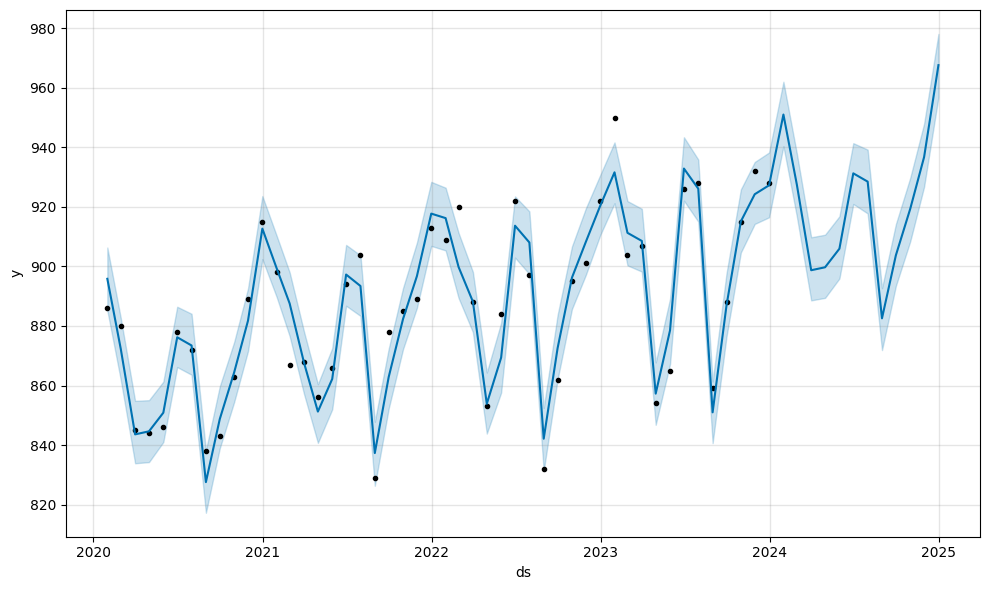

In [101]:
from prophet import Prophet

modelo_total = Prophet()
modelo_total.fit(df_prophet_total)

futuro_total = modelo_total.make_future_dataframe(periods=12, freq='M')
predicciones_total = modelo_total.predict(futuro_total)

fig = modelo_total.plot(predicciones_total)
plt.show()

## 2.2. Modelo para ventas por medicamento

El objetivo principal de este proyecto no es predecir las ventas anuales totales, sino las ventas mensuales de cada medicamento, con el fin de gestionar adecuadamente el inventario y no sufrir sobrestock.
Para ello, el modelo se va a centrar en aquellos medicamentos que tengan ventas en al menos 24 meses de los últimos cuatro años.

In [102]:
# Medicamentos con al menos 24 meses con ventas > 0
medicamentos_validos = []
for nombre in df_Kern_train['Denominacion'].unique():
    df_med = df_Kern_train[df_Kern_train["Denominacion"] == nombre]
    if (df_med["Ventas"] > 0).sum() >= 24:
        medicamentos_validos.append(nombre)

df_pred_med = pd.DataFrame()

# Predicciones para cada medicamento
for nombre in medicamentos_validos:
    df_med = df_Kern_train[df_Kern_train["Denominacion"] == nombre][["Fecha", "Ventas"]].copy()
    df_med = df_med.rename(columns={"Fecha": "ds", "Ventas": "y"})

    modelo_med = Prophet()
    modelo_med.fit(df_med)

    futuro_med = modelo_med.make_future_dataframe(periods=12, freq='M')
    pred_med = modelo_med.predict(futuro_med)

    pred_med = pred_med[["ds", "yhat"]].copy()
    pred_med["yhat"] = pred_med["yhat"].round().astype(int)
    pred_med["Denominacion"] = nombre

    df_pred_med = pd.concat([df_pred_med, pred_med], ignore_index=True)

# Se eliminan los espacios vacíos en los nombres
df_pred_med["Denominacion"]=df_pred_med["Denominacion"].str.strip()
# Se guarda el dataframe
df_pred_med.to_csv("Predicciones_Kern.csv", index=False)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp79u4x25_/qwqkkuzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp79u4x25_/g08r0bz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33112', 'data', 'file=/tmp/tmp79u4x25_/qwqkkuzy.json', 'init=/tmp/tmp79u4x25_/g08r0bz_.json', 'output', 'file=/tmp/tmp79u4x25_/prophet_modelpp2cut70/prophet_model-20250521171045.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:10:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

### 2.2.1. Diazepan Prodes 5 MG 30 COMP


<Axes: title={'center': 'DIAZEPAN PRODES  5 MG 30 COMP'}, xlabel='ds'>

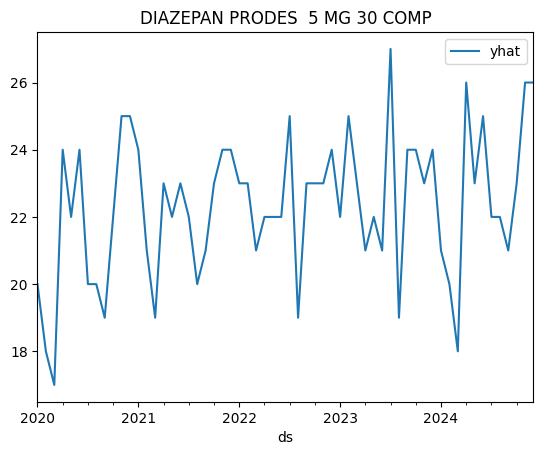

In [103]:
med = 'DIAZEPAN PRODES  5 MG 30 COMP'
df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']].set_index('ds').plot(title=med)

A simple vista parece que la predicción puede ser adecuada considerando el comportamiento de las ventas en los últimos años.
Cabe destacar que el modelo detecta un crecimiento en la pendiente de la gráfica a mediados de año, generando una caída brusca en las ventas.
A falta de evaluar el modelo con los datos de test, parece que predice de manera aceptable el modelo.

### 2.2.2. Paracetamol 1GR 40 COMP

<Axes: title={'center': 'PARACETAMOL KERN 1GRX40 CO EFG'}, xlabel='ds'>

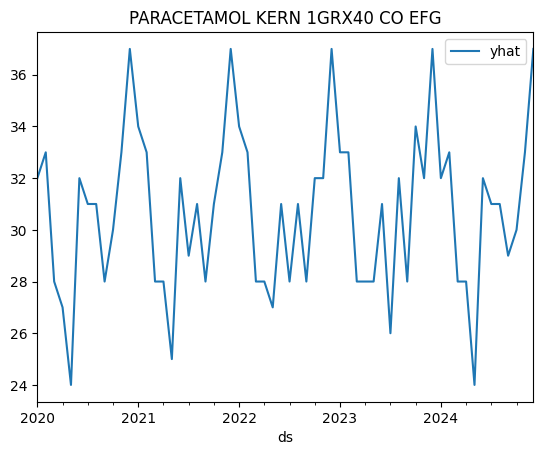

In [104]:
med = 'PARACETAMOL KERN 1GRX40 CO EFG'
df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']].set_index('ds').plot(title=med)

En esta ocasión sin embargo, el modelo no parece predecir con tanta exactitud.
De 2020 a 2024 las ventas mensuales aumentan en la mayoría de meses del año, no obstante, las ventas en los últimos meses del año decaen. Parece que el modelo no es capaz de observar correctamente este comportamiento, ya que refleja un crecimiento sin precedentes en la predicción de inicios del año 2025.

### 2.2.3. Metformina 1000 MG 30 COMP

<Axes: title={'center': 'METFORMINA KERN 1000 MG 30 COMP EFG'}, xlabel='ds'>

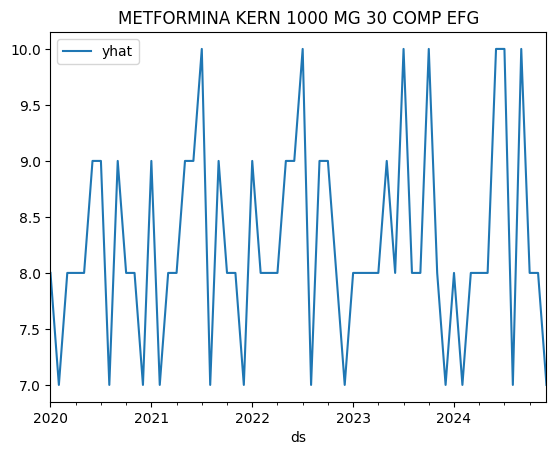

In [105]:
med = 'METFORMINA KERN 1000 MG 30 COMP EFG'
df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']].set_index('ds').plot(title=med)

Si observamos predicciones de medicamentos con menos unidades vendidas, parece que al modelo le resulta más sencillo realizar una predicción más acertada.

## 2.3. Evaluación de los modelos

### 2.3.1. Evaluación Modelo ventas totales

* Se prepara el dataset de test

In [106]:
df_Kern_test_total = df_Kern_test.groupby("Fecha")["Ventas"].sum().reset_index()
df_Kern_test_total.columns = ['ds', 'y']
df_Kern_test_total['ds'] = pd.to_datetime(df_Kern_test_total['ds'])
df_Kern_test_total.head()

,ds,y
0,2024-01-01,929
1,2024-02-01,949
2,2024-03-01,919
3,2024-04-01,886
4,2024-05-01,910


* Se prepara el dataframe de las predicciones

In [107]:
pred_total_2024 = predicciones_total[predicciones_total['ds'].dt.year == 2024][['ds', 'yhat']]
pred_total_2024['ds'] = pred_total_2024['ds'].dt.to_period('M').dt.to_timestamp()
pred_total_2024['yhat'] = pred_total_2024['yhat'].round().astype(int)
pred_total_2024['ds'] = pd.to_datetime(pred_total_2024['ds'])
pred_total_2024.head()

,ds,yhat
48,2024-01-01,951
49,2024-02-01,927
50,2024-03-01,899
51,2024-04-01,900
52,2024-05-01,906


* Evaluamos el modelo

In [108]:
evaluacion_total = df_Kern_test_total.merge(pred_total_2024, on='ds', how='inner')

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(evaluacion_total['y'], evaluacion_total['yhat'])
rmse = np.sqrt(mean_squared_error(evaluacion_total['y'], evaluacion_total['yhat']))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 16.92, RMSE: 18.16


* Gráficas

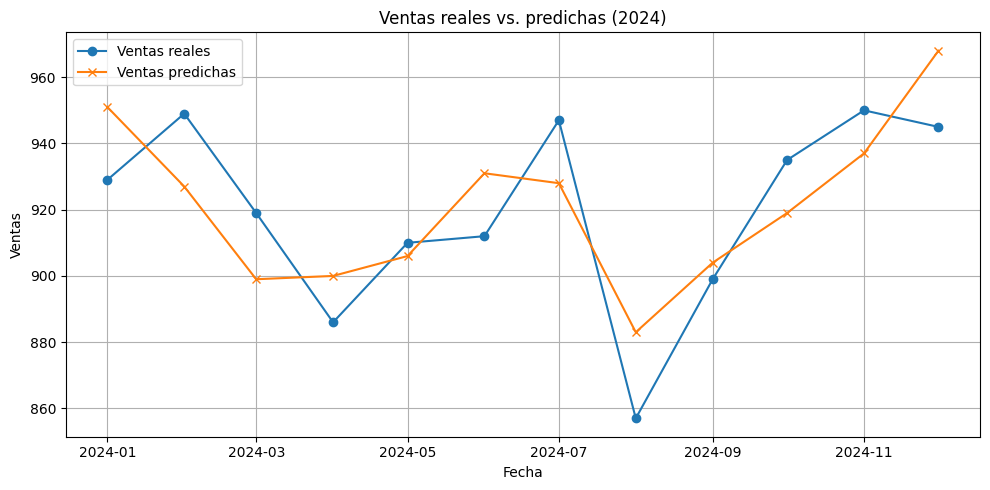

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(evaluacion_total['ds'], evaluacion_total['y'], label='Ventas reales', marker='o')
plt.plot(evaluacion_total['ds'], evaluacion_total['yhat'], label='Ventas predichas', marker='x')
plt.title('Ventas reales vs. predichas (2024)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo presenta un error absoluto medio (MAE) de 16.92 unidades y un error cuadrático medio (RMSE) de 18.16 unidades. Considerando que las ventas mensuales de este medicamento oscilan entre 800 y 1000 unidades, el MAE representa un error relativo del 1.7% al 2.1%, lo cual indica una alta precisión en las predicciones.

### 2.3.2. Evaluación Modelo ventas de medicamentos

* DIAZEPAN PRODES 5 MG

In [132]:
med = 'DIAZEPAN PRODES  5 MG 30 COMP'
df_pred_med['Denominacion'].str.strip()
df_pred_diaz=df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']]

In [133]:
df_Kern_test['Denominacion'] = df_Kern_test['Denominacion'].str.strip()
df_Kern_test['Fecha'] = pd.to_datetime(df_Kern_test['Fecha']).dt.to_period('M').dt.to_timestamp('M')
df_Kern_test_med = df_Kern_test[df_Kern_test['Denominacion']==med][['Fecha', 'Ventas']]
df_Kern_test_med.columns = ['ds', 'y']

In [134]:
evaluacion_med = df_Kern_test_med.merge(df_pred_diaz, on='ds', how='inner')

In [135]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(evaluacion_med['y'], evaluacion_med['yhat'])
rmse = np.sqrt(mean_squared_error(evaluacion_med['y'], evaluacion_med['yhat']))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 3.50, RMSE: 3.87


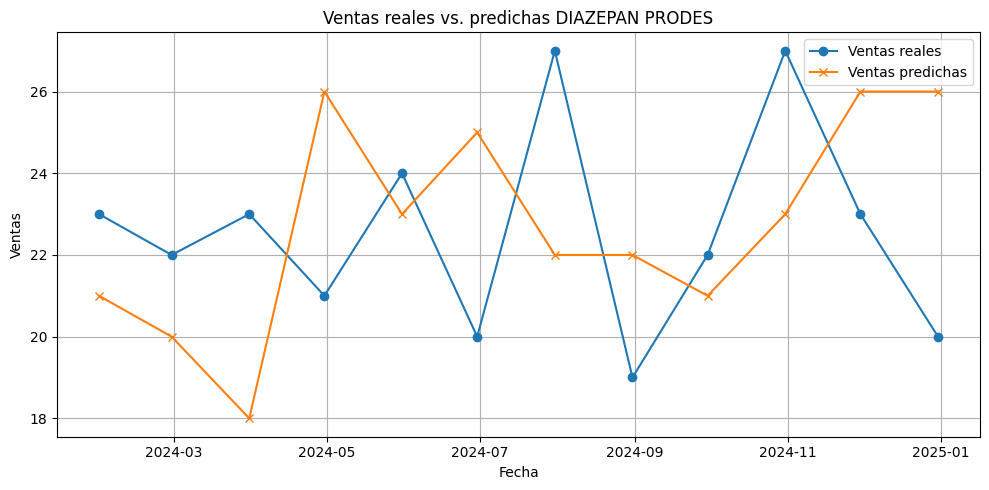

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(evaluacion_med['ds'], evaluacion_med['y'], label='Ventas reales', marker='o')
plt.plot(evaluacion_med['ds'], evaluacion_med['yhat'], label='Ventas predichas', marker='x')
plt.title(f'Ventas reales vs. predichas {med[:15]}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* IBUPROFENO

In [143]:
# Nuevo medicamento Ibuprofeno
med = 'IBUPROFENO KERN 600X40 COM EFG'
df_pred_med['Denominacion'].str.strip()
df_pred_ibu=df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']]

df_Kern_test_med = df_Kern_test[df_Kern_test['Denominacion']==med][['Fecha', 'Ventas']]
df_Kern_test_med.columns = ['ds', 'y']

#Evaluamos de nuevo
evaluacion_med = df_Kern_test_med.merge(df_pred_ibu, on='ds', how='inner')

mae = mean_absolute_error(evaluacion_med['y'], evaluacion_med['yhat'])
rmse = np.sqrt(mean_squared_error(evaluacion_med['y'], evaluacion_med['yhat']))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 1.58, RMSE: 1.76


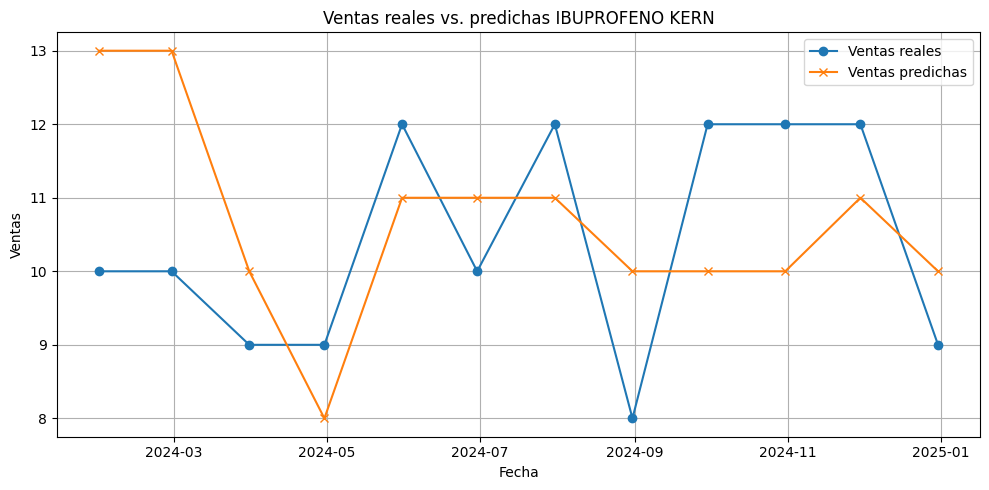

In [144]:
# Graficamos los nuevos resultados

plt.figure(figsize=(10, 5))
plt.plot(evaluacion_med['ds'], evaluacion_med['y'], label='Ventas reales', marker='o')
plt.plot(evaluacion_med['ds'], evaluacion_med['yhat'], label='Ventas predichas', marker='x')
plt.title(f'Ventas reales vs. predichas {med[:15]}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* SULPIRIDA

In [148]:
# Nuevo medicamento Ebastina
med = 'SULPIRIDA KERN PHARMA 50 MG 30 CAPS EFG'
df_pred_med['Denominacion'].str.strip()
df_pred_sul=df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']]

df_Kern_test_med = df_Kern_test[df_Kern_test['Denominacion']==med][['Fecha', 'Ventas']]
df_Kern_test_med.columns = ['ds', 'y']

#Evaluamos de nuevo
evaluacion_med = df_Kern_test_med.merge(df_pred_sul, on='ds', how='inner')

mae = mean_absolute_error(evaluacion_med['y'], evaluacion_med['yhat'])
rmse = np.sqrt(mean_squared_error(evaluacion_med['y'], evaluacion_med['yhat']))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 1.42, RMSE: 1.80


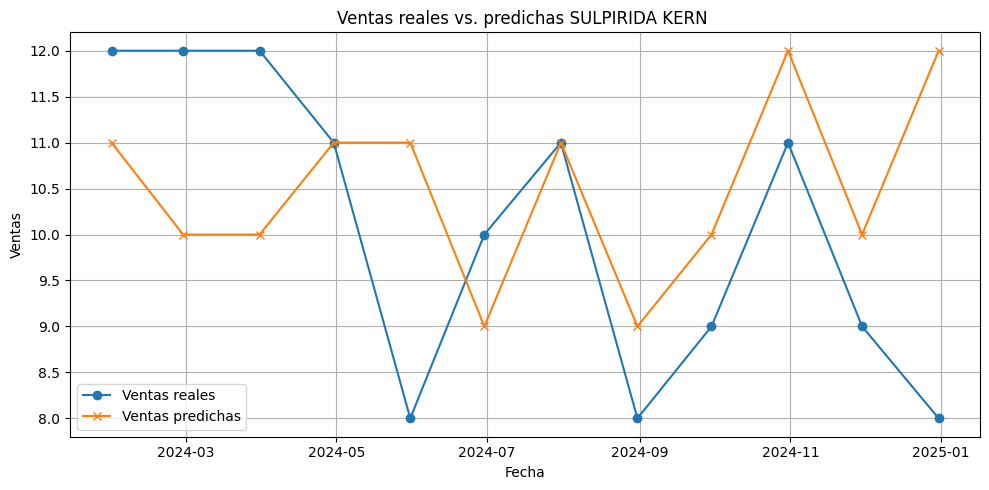

In [149]:
# Graficamos los nuevos resultados

plt.figure(figsize=(10, 5))
plt.plot(evaluacion_med['ds'], evaluacion_med['y'], label='Ventas reales', marker='o')
plt.plot(evaluacion_med['ds'], evaluacion_med['yhat'], label='Ventas predichas', marker='x')
plt.title(f'Ventas reales vs. predichas {med[:15]}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* EBASTINA

In [146]:
# Nuevo medicamento Ebastina
med = 'EBASTINA KERN 20 MG 20 COMP'
df_pred_med['Denominacion'].str.strip()
df_pred_eba=df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']]

df_Kern_test_med = df_Kern_test[df_Kern_test['Denominacion']==med][['Fecha', 'Ventas']]
df_Kern_test_med.columns = ['ds', 'y']

#Evaluamos de nuevo
evaluacion_med = df_Kern_test_med.merge(df_pred_eba, on='ds', how='inner')

mae = mean_absolute_error(evaluacion_med['y'], evaluacion_med['yhat'])
rmse = np.sqrt(mean_squared_error(evaluacion_med['y'], evaluacion_med['yhat']))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 0.58, RMSE: 0.76


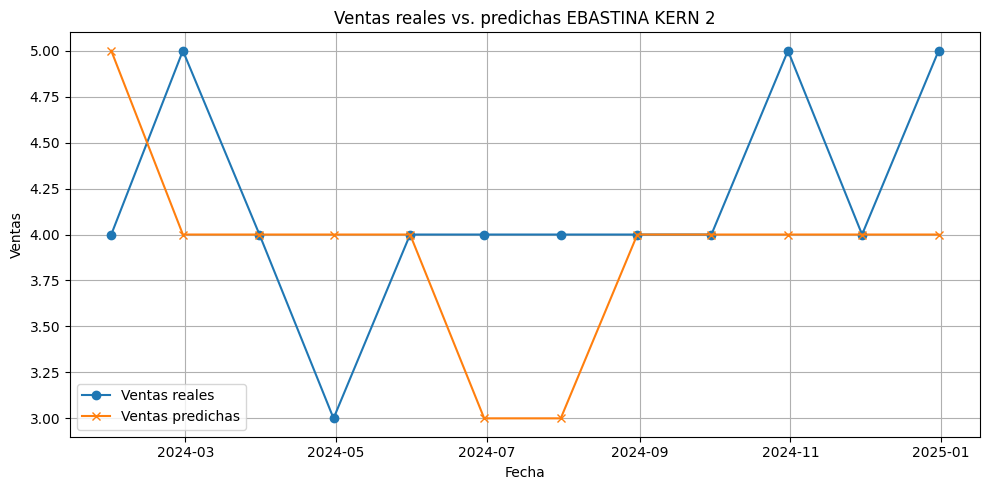

In [147]:
# Graficamos los nuevos resultados

plt.figure(figsize=(10, 5))
plt.plot(evaluacion_med['ds'], evaluacion_med['y'], label='Ventas reales', marker='o')
plt.plot(evaluacion_med['ds'], evaluacion_med['yhat'], label='Ventas predichas', marker='x')
plt.title(f'Ventas reales vs. predichas {med[:15]}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.4. CONCLUSIÓN

El modelo ha sido evaluado en medicamentos con volúmenes de venta reducidos, por lo que la precisión en las predicciones de ventas mensuales de medicamentos es lógico que sea menor. No obstante, a pesar de ello, los resultados han sido aceptables.

* **Diazepam** (20–25 uds/mes): **MAE** de 3.50 y **RMSE** de 3.87, lo que supone un error del 14–17%.

* **Ibuprofeno** (8–12 uds/mes): **MAE** de 1.58 y **RMSE** de 1.76, con un error relativo del 13–20%.

* **Sulpirida** (8–12 uds/mes): **MAE** de 1.42 y **RMSE** de 1.80, con un error estimado del 12–18%.

* **Ebastina** (3–5 uds/mes): **MAE** de 0.58 y **RMSE** de 0.76, lo que representa un error del 12–19%.

Estos resultados indican que, pese a la mayor variabilidad que puede afectar a productos con pocas unidades vendidas, el modelo mantiene errores absolutos bajos y proporcionales al volumen de ventas, demostrando su fiabilidad para realizar predicciones incluso en casos con demanda reducida.
Sin embargo, el modelo tendrá una mayor efectividad en las predicciones cuando los volúmenes de venta sean mayores, como por ejemplo con las ventas anuales, donde los resultados fueron excelentes, un error relativo del 1.7% al 2.1%.